# Text to Image

在這項工作中，我們有興趣將以單句人類書寫描述的文字直接翻譯成圖像像素。例如，“這朵花的花瓣是黃色的，有一個褶皺的雄蕊”，以及“這朵粉紅色和黃色的花有一個美麗的黃色中心，有很多雄蕊”。您需要開發一種新穎的深度架構和GAN公式，以有效地將視覺概念從字符轉換為像素。

更具體地說，鑒於一組文本，您的任務是生成大小為64x64x3的合理圖像，以說明相應的文本。在這裡，我們使用Oxford-102 flower dataset及其配對的文本作為我們的訓練數據集。

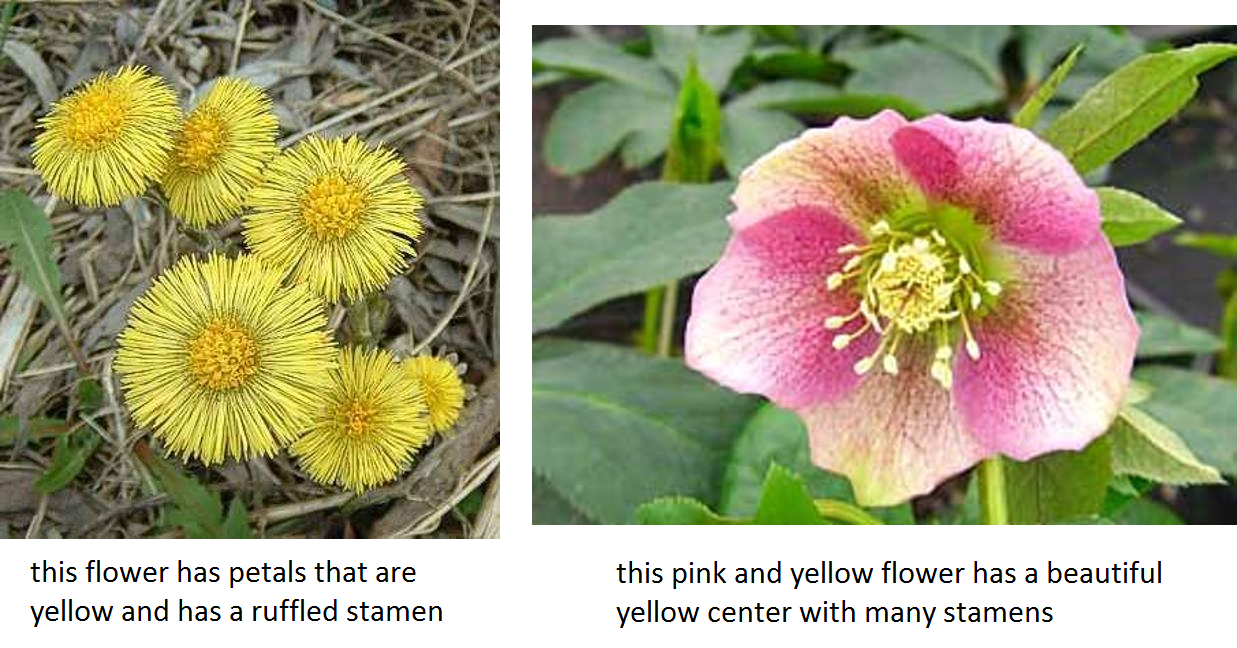

- 7370 images as training set, where each images is annotated with at most 10 texts.
- 819 texts for testing. You must generate 1 64x64x3 image for each text.

# Conditional GAN


給定一段文本，為了生成能夠說明它的圖像，我們的模型必須滿足一些要求：

1. 我們的模型應該具備理解和提取給定文本含義的能力。
    - 使用RNN或其他語言模型，如BERT、ELMo或XLNet，來捕捉文本的含義。
2. 我們的模型應該能夠生成圖像。
    - 使用GAN生成高質量圖像。
3. GAN生成的圖像應該能夠說明文本。
    - 使用有條件的GAN生成在給定文本條件下的圖像

生成對抗網絡可以擴展為一種有條件的模型，如果生成器和判別器都是在一些額外信息 y 的條件下的。我們可以通過將 y 作為附加輸入層餵入判別器和生成器來進行條件設置。

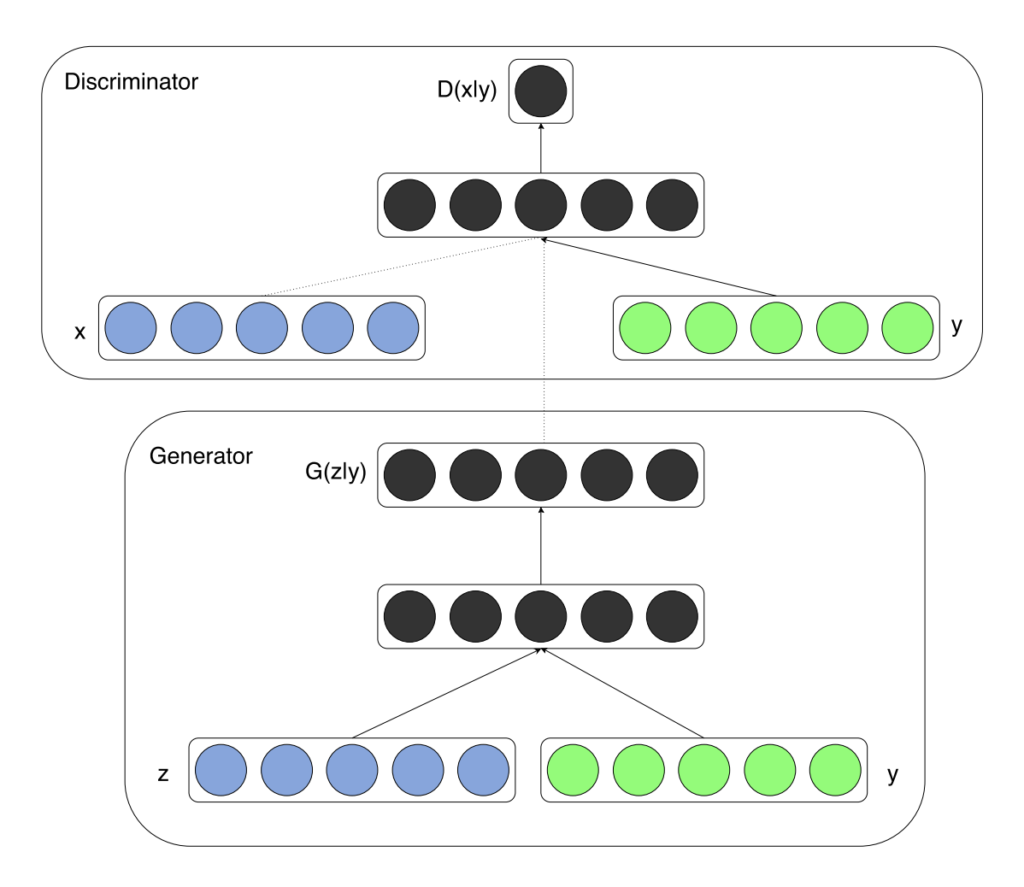

在GAN模型中使用一些額外信息有兩個動機：

1. 改進GAN。
2. 生成有針對性的圖像。

與輸入圖像相關聯的額外信息，例如類別標籤，可用於改進GAN。這種改進可以以更穩定的訓練、更快的訓練和/或生成的圖像具有更好品質的形式呈現。

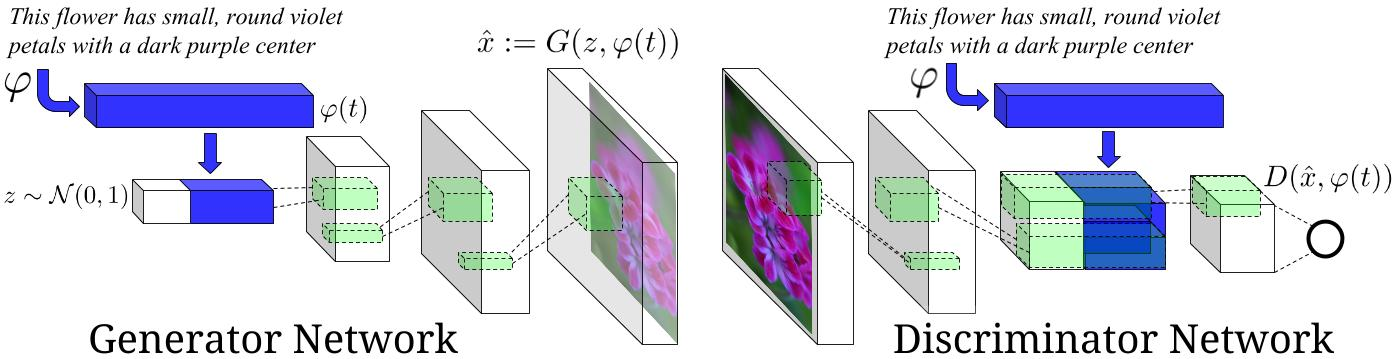

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

2023-12-11 18:26:55.311863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Preprocess Text

由於處理原始字符串效率低下，我們已經為您進行了一些數據預處理：

1. 刪除超過MAX_SEQ_LENGTH（20）的文本。
2. 刪除文本中的所有標點符號。
3. 將dictionary/vocab.npy 中的每個詞彙進行編碼。
4. 用整數ID序列表示文本。
5. 將稀有詞彙替換為 `<RARE>` 標記，以減少詞彙大小，實現更有效的訓練。
6. 對每個文本添加 <PAD> 作為填充，以確保它們的長度都相等於MAX_SEQ_LENGTH（20）。

值得注意的是，在這個任務中，不需要在每個文本中附加 `<ST>` 和 `<ED>`，因為我們不需要生成任何序列。

為了確保對原始文本的編碼的正確性，我們可以通過查找詞彙字典解碼序列詞彙ID：

- dictionary/word2Id.npy 是一個將詞彙映射到ID的numpy數組。
- dictionary/id2Word.npy 是一個將ID映射回詞彙的numpy數組。

In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


# Dataset


用於訓練的資料集文件夾中包含以下文件：

- ./dataset/text2ImgData.pkl 是一個 Pandas DataFrame，具有 'Captions' 和 'ImagePath' 兩個屬性。
    - 'Captions'：包含 1 到 10 個標題的文本 ID 列表。
    - 'ImagePath'：存儲了相應影像的路徑。
- ./102flowers/ 是包含所有訓練影像的目錄。
- ./dataset/testData.pkl 是一個 Pandas DataFrame，具有 'ID' 和 'Captions' 兩個屬性，其中包含測試數據。

In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [6]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


# Create Dataset by Dataset API

In [7]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    print(len(captions)))
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [8]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)

/tmp/ipykernel_3018751/3313815207.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


# Conditional GAN Model

As mentioned above, there are three models in this task, text encoder, generator and discriminator.

# Text Encoder

一個能夠捕捉輸入文本含義的循環神經網絡（RNN）編碼器。

- 輸入：文本，這是一個 ID 列表。
- 輸出：嵌入或輸入文本的隱藏表示。

In [9]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state = self.gru(text, initial_state = hidden)
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

# Generator


一個圖像生成器，生成以輸入文本為基礎的目標圖像。

- 輸入：輸入文本的隱藏表示和帶有隨機種子的隨機噪音 z。
- 輸出：受給定文本條件影響的目標圖像，大小為 64x64x3。

In [10]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d2(text_concat)
        
        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)
        
        return logits, output

# Discriminator

一個能夠區分真實和虛假影像的二元分類器：

1. 真實影像
    - 輸入：真實影像和相應的文本
    - 輸出：代表結果的浮點數，預期值為 1。

2. 虛假影像
    - 輸入：生成的影像和相應的文本
    - 輸出：代表結果的浮點數，預期值為 0。

In [11]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
    
    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)
        
        img = self.flatten(img)
        img = self.d_img(img)
        img = tf.nn.leaky_relu(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [12]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

In [13]:
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

# Loss Function and Optimization


儘管有條件的生成對抗網絡（conditional GAN）模型相當複雜，但用於優化網絡的損失函數相對簡單。實際上，它僅僅是一個二元分類任務，因此我們使用交叉熵作為我們的損失。

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 1
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [17]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
@tf.function
def train_step(real_image, caption, hidden):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embed, hidden = text_encoder(caption, hidden)
        _, fake_image = generator(text_embed, noise)
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss

In [19]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise)
    return fake_image

# Visualiztion
During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.

In [20]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [21]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

We always use same random seed and same sentences during training, which is more convenient for us to evaluate the quality of generated image.

In [22]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])


/tmp/ipykernel_3018751/646496249.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


# Training

In [23]:
if not os.path.exists('samples/demo'):
    os.makedirs('samples/demo')

In [24]:
def train(dataset, epochs):
    # hidden state of RNN
    hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        for image, caption in dataset:
            g_loss, d_loss = train_step(image, caption, hidden)
            g_total_loss += g_loss
            d_total_loss += d_loss
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # save the model
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed, hidden)
            save_images(fake_image, [ni, ni], 'samples/demo/train_{:02d}.jpg'.format(epoch))

In [25]:
train(dataset, hparas['N_EPOCH'])

Epoch 1, gen_loss: 0.5422, disc_loss: 0.9793
Time for epoch 1 is 6.1115 sec
Epoch 2, gen_loss: 0.6238, disc_loss: 0.8724
Time for epoch 2 is 4.0486 sec
Epoch 3, gen_loss: 0.8866, disc_loss: 0.6576
Time for epoch 3 is 4.0843 sec
Epoch 4, gen_loss: 1.4635, disc_loss: 0.3550
Time for epoch 4 is 4.1089 sec
Epoch 5, gen_loss: 2.2832, disc_loss: 0.1440
Time for epoch 5 is 3.9733 sec
Epoch 6, gen_loss: 2.0369, disc_loss: 0.1907
Time for epoch 6 is 3.9607 sec
Epoch 7, gen_loss: 2.5511, disc_loss: 0.1267
Time for epoch 7 is 3.9959 sec
Epoch 8, gen_loss: 3.0661, disc_loss: 0.1080
Time for epoch 8 is 4.3139 sec
Epoch 9, gen_loss: 3.1329, disc_loss: 0.1331
Time for epoch 9 is 4.0240 sec
Epoch 10, gen_loss: 3.3717, disc_loss: 0.1475
Time for epoch 10 is 4.0417 sec
Epoch 11, gen_loss: 3.5137, disc_loss: 0.2275
Time for epoch 11 is 3.9974 sec
Epoch 12, gen_loss: 3.7393, disc_loss: 0.2899
Time for epoch 12 is 4.0098 sec
Epoch 13, gen_loss: 3.4046, disc_loss: 0.3509
Time for epoch 13 is 3.9976 sec
Epoc

# <center>Evaluation<center/>

dataset/testData.pkl is a pandas dataframe containing testing text with attributes 'ID' and 'Captions'.

- 'ID': text ID used to name generated image.
- 'Captions': text used as condition to generate image.

For each captions, you need to generate inference_ID.png to evaluate quality of generated image. You must name the generated image in this format, otherwise we cannot evaluate your images.

# Testing Dataset

If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.

In [26]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [27]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

/tmp/ipykernel_3018751/466323065.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


In [28]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

# Inferece

In [29]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [30]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [31]:
checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [32]:
inference(testing_dataset)

Time for inference is 0.9112 sec


# Inception Score & Cosine Similarity


在這個競賽中，我們使用Inception Score和余弦距離作為評估生成圖像的質量和多樣性的最終分數。您可以在這篇文章中找到有關Inception Score的更多細節。最終分數基於以下兩個方面：

- 圖像與給定內容的相似性。生成的圖像與給定文本有多相似？
- 生成圖像的KL散度。生成的圖像是否非常多樣化？

在生成了具有給定測試文本的圖像之後，您需要運行評估腳本以生成score.csv文件，然後將其上傳到Kaggle以獲得最終分數。

1. 運行評估腳本以生成score.csv
    1. 打開終端並移動到包含inception_score.py的文件夾。否則，您必須修改文件中使用的路徑。
    2. 運行命令：python ./inception_score.py [argv1] [argv2] [argv3]
        - argv1：生成圖像（推斷）的目錄。
        - argv2：輸出文件及其名稱的目錄。
        - argv3：批次大小。請設置批次大小為1、2、3、7、9、21、39，以避免餘數。

例如，運行以下命令：python inception_score.py ../inference/demo ../score_demo.csv 39。

請注意，評估需要在GPU上運行，請確保GPU資源可用。